# Convolutional Neural Networks
In this notebook we will learn how to train a simple Convolutional Neural Network (CNN) for image classification using PyTorch.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image

### Load dataset

In [2]:
# torchvision has some datasets already included, so we will load MNIST through torchvision
# first we need to define the transformations
data_aug = transforms.Compose([transforms.ToTensor()]) # the ToTensor transform scales the image into [0., 1.0] range

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=data_aug,
)
validation_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=data_aug,
)

Training size: 60000
Validation size: 8000 
Test size: 2000


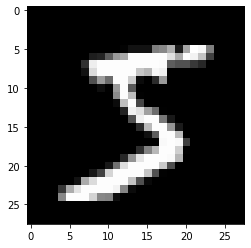

In [4]:
# Divide dataset into train-val-test subsets
indices = list(range(len(validation_data)))
np.random.shuffle(indices, )

test_size = 0.2 * len(indices)
split = int(np.floor(test_size))
val_idx, test_idx = indices[split:], indices[:split]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

print(f'Training size: {len(training_data)}\nValidation size: {len(val_idx)} \nTest size: {len(test_idx)}')

plt.imshow(training_data[0][0][0,:,:], cmap='gray');

In [5]:
# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Now we need to define a Dataloader, which allows us to automatically batch our inputs, do sampling and multiprocess data loading
batch_size = 64
num_workers = 2 # how many processes are used to load the data

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
validation_dataloader = DataLoader(validation_data, sampler=val_sampler, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)
test_dataloader = DataLoader(validation_data, sampler=test_sampler, batch_size=1, shuffle=False, num_workers=num_workers, drop_last=False)

Using cuda device


## Defining the model

Create a CNN with the following structure:

1. convolutional layer with 32 output channels and 3x3 kernel
2. ReLU activation layer
3. convolutional layer with 32 input/output channels and 3x3 kernel
4. ReLU activation layer
5. max pooling layer with a kernel size of 2
6. dropout with 0.25 probability
7. flattening layer (to convert the 3D tensors into 1D tensors to be fed to the dense layers)
8. dense/linear layer with 128 output channels
9. ReLU activation layer
10. dropout layer with 0.5 probability
11. dense/linear layer with 10 output channels (10 classes of MNIST)

You can use PyTorch's layers: https://pytorch.org/docs/stable/nn.html (Conv2d, ReLU, Linear, MaxPool2d, Dropout, Flatten)




In [6]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.pool_size = 2
        self.nb_filters = 32
        self.kernel_size = 3

        self.layers = nn.Sequential(
            nn.Conv2d(1, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.Conv2d(self.nb_filters, self.nb_filters, self.kernel_size),
            nn.ReLU(),
            nn.MaxPool2d(self.pool_size),
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(4608, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

model = ConvolutionalNeuralNetwork().to(device)  # Put model in device (GPU or CPU)
print(model)

ConvolutionalNeuralNetwork(
  (layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.25, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4608, out_features=128, bias=True)
    (8): ReLU()
    (9): Dropout(p=0.5, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Interpret the implemented architecture and try to answer the following questions:

### **a)** What is the shape (width, height and # of channels) of the output tensor after the first convolution layer?

# TODO:


### **b)** And after the first 3 layers (convolution+convolution+pooling)?

# TODO:

### **c)** How many parameters (weights) does the model have? Contrary to Keras, PyTorch does not have an official method for counting the number of parameters of a model, but you can use [torchsummary](https://github.com/sksq96/torchsummary).

In [7]:
from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           9,248
              ReLU-4           [-1, 32, 24, 24]               0
         MaxPool2d-5           [-1, 32, 12, 12]               0
           Dropout-6           [-1, 32, 12, 12]               0
           Flatten-7                 [-1, 4608]               0
            Linear-8                  [-1, 128]         589,952
              ReLU-9                  [-1, 128]               0
          Dropout-10                  [-1, 128]               0
           Linear-11                   [-1, 10]           1,290
Total params: 600,810
Trainable params: 600,810
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

## Train the model

In [8]:
loss_fn = nn.CrossEntropyLoss()  # Already includes the Softmax activation
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [12]:
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
	if is_train:
		assert optimizer is not None, "When training, please provide an optimizer."
	  
	num_batches = len(dataloader)

	if is_train:
		model.train() # put model in train mode
        
	else:
		model.eval()

	total_loss = 0.0
	preds = []
	labels = []

	with torch.set_grad_enabled(is_train):
		for batch, (X, y) in enumerate(tqdm(dataloader)):
			X, y = X.to(device), y.to(device)

			# Compute prediction error
			pred = model(X)
			loss = loss_fn(pred, y)

			if is_train:
				# Backpropagation
				optimizer.zero_grad()
				loss.backward()
				optimizer.step()

			# Save training metrics
			total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

			probs = F.softmax(pred, dim=1)
			final_pred = torch.argmax(probs, dim=1)
			preds.extend(final_pred.cpu().numpy())
			labels.extend(y.cpu().numpy())

	return total_loss / num_batches, accuracy_score(labels, preds)

## Analyse training evolution

In [14]:
num_epochs = 10
train_history = {'loss': [], 'accuracy': []}
val_history = {'loss': [], 'accuracy': []}
best_val_loss = np.inf
print("Start training...")

for t in range(num_epochs):
	print(f"\nEpoch {t+1}")
	train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)
	print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")
	val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
	print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

	# save model when val loss improves
	if val_loss < best_val_loss:
		best_val_loss = val_loss
		save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
		torch.save(save_dict, 'best_model.pth')

	# save latest model
	save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
	torch.save(save_dict, 'latest_model.pth')

	# save training history for plotting purposes
	train_history["loss"].append(train_loss)
	train_history["accuracy"].append(train_acc)

	val_history["loss"].append(val_loss)
	val_history["accuracy"].append(val_acc)
	
print("Finished")

Start training...

Epoch 1


100%|██████████| 937/937 [00:05<00:00, 163.49it/s]


Train loss: 0.616 	 Train acc: 0.812


100%|██████████| 125/125 [00:01<00:00, 65.12it/s] 


Val loss: 0.392 	 Val acc: 0.897

Epoch 2


100%|██████████| 937/937 [00:06<00:00, 152.00it/s]


Train loss: 0.533 	 Train acc: 0.837


100%|██████████| 125/125 [00:01<00:00, 62.69it/s] 


Val loss: 0.347 	 Val acc: 0.904

Epoch 3


100%|██████████| 937/937 [00:06<00:00, 149.21it/s]


Train loss: 0.483 	 Train acc: 0.852


100%|██████████| 125/125 [00:01<00:00, 63.78it/s] 


Val loss: 0.316 	 Val acc: 0.911

Epoch 4


100%|██████████| 937/937 [00:05<00:00, 166.84it/s]


Train loss: 0.447 	 Train acc: 0.865


100%|██████████| 125/125 [00:01<00:00, 64.40it/s] 


Val loss: 0.292 	 Val acc: 0.916

Epoch 5


100%|██████████| 937/937 [00:05<00:00, 165.84it/s]


Train loss: 0.421 	 Train acc: 0.874


100%|██████████| 125/125 [00:01<00:00, 67.35it/s] 


Val loss: 0.271 	 Val acc: 0.921

Epoch 6


100%|██████████| 937/937 [00:06<00:00, 150.16it/s]


Train loss: 0.398 	 Train acc: 0.879


100%|██████████| 125/125 [00:02<00:00, 61.36it/s] 


Val loss: 0.256 	 Val acc: 0.925

Epoch 7


100%|██████████| 937/937 [00:05<00:00, 156.45it/s]


Train loss: 0.380 	 Train acc: 0.886


100%|██████████| 125/125 [00:01<00:00, 73.10it/s] 


Val loss: 0.242 	 Val acc: 0.930

Epoch 8


100%|██████████| 937/937 [00:05<00:00, 169.10it/s]


Train loss: 0.362 	 Train acc: 0.891


100%|██████████| 125/125 [00:01<00:00, 70.45it/s] 


Val loss: 0.230 	 Val acc: 0.934

Epoch 9


100%|██████████| 937/937 [00:05<00:00, 183.58it/s]


Train loss: 0.350 	 Train acc: 0.895


100%|██████████| 125/125 [00:01<00:00, 71.44it/s] 


Val loss: 0.220 	 Val acc: 0.936

Epoch 10


100%|██████████| 937/937 [00:05<00:00, 179.30it/s]


Train loss: 0.336 	 Train acc: 0.899


100%|██████████| 125/125 [00:01<00:00, 71.51it/s] 

Val loss: 0.210 	 Val acc: 0.939
Finished


In [16]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

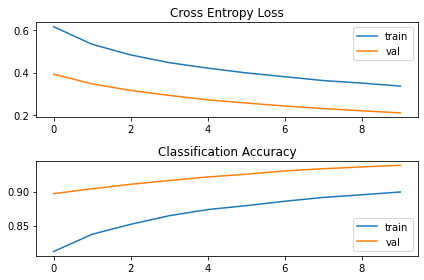

In [17]:
plotTrainingHistory(train_history, val_history)

## Test the model

In [18]:
# Evaluate the model in the test set

# load the best model (i.e. model with the lowest val loss...might not be the last model)
# we could also load the optimizer and resume training if needed

model = ConvolutionalNeuralNetwork().to(device)
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model'])

test_loss, test_acc = epoch_iter(test_dataloader, model, loss_fn, is_train=False)
print(f"\nTest Loss: {test_loss:.3f} \nTest Accuracy: {test_acc:.3f}")

100%|██████████| 2000/2000 [00:04<00:00, 411.61it/s]


Test Loss: 0.194 
Test Accuracy: 0.943


In [19]:
def showErrors(model, dataloader, num_examples=20):    
	plt.figure(figsize=(15, 15))

	for ind, (X, y) in enumerate(dataloader):
		if ind >= 20: 
			break

		X, y = X.to(device), y.to(device)    
		pred = model(X)
		probs = F.softmax(pred, dim=1)
		final_pred = torch.argmax(probs, dim=1)

		plt.subplot(10, 10, ind + 1)
		plt.axis("off")
		plt.text(0, -1, y[0].item(), fontsize=14, color='green') # correct
		plt.text(8, -1, final_pred[0].item(), fontsize=14, color='red')  # predicted
		plt.imshow(X[0][0,:,:].cpu(), cmap='gray')
		
	plt.show()

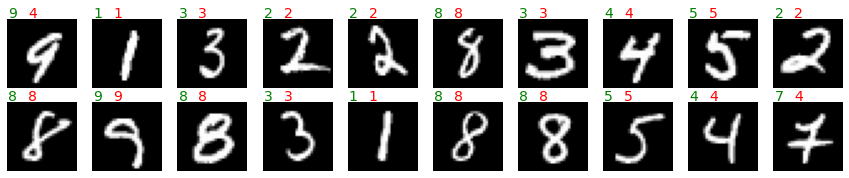

In [20]:
showErrors(model, test_dataloader)

## Additional exercises

a) What is data augmentation and why is it useful? Explore some data augmentation techniques, by using some transforms from [torchvision](https://pytorch.org/vision/stable/index.html).

b) Since training a complex model can take a very long time to train, model checkpoints can be saved and loaded later to resume the training. Explore how this can be done: https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

c) Train and test the previous model on the Fashion-MNIST and CIFAR-10 datasets. Some adaptations to the code are necessary for the latter dataset.


## Challenges (closer to the project)
Adapt the previous model, or use any of the well-known CNN architectures, to tackle one of (or both) these competitions, that consist of a binary medical image classification problem.

a) Identify metastatic cancer in small image patches (32x32) taken from larger digital pathology scans https://www.kaggle.com/c/histopathologic-cancer-detection

b) Classify CT images into positive or negative COVID-19, depending if the image has or does not have clinical findings of COVID-19 https://covid-ct.grand-challenge.org/Data/